### Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is a method in natural language processing (NLP) that combines two key components:

Retrieval: Searches for relevant documents or data (from a database, knowledge base, or other sources) based on the input query.
Generation: Uses a language model (like GPT) to generate a response by conditioning on both the input query and the retrieved information.

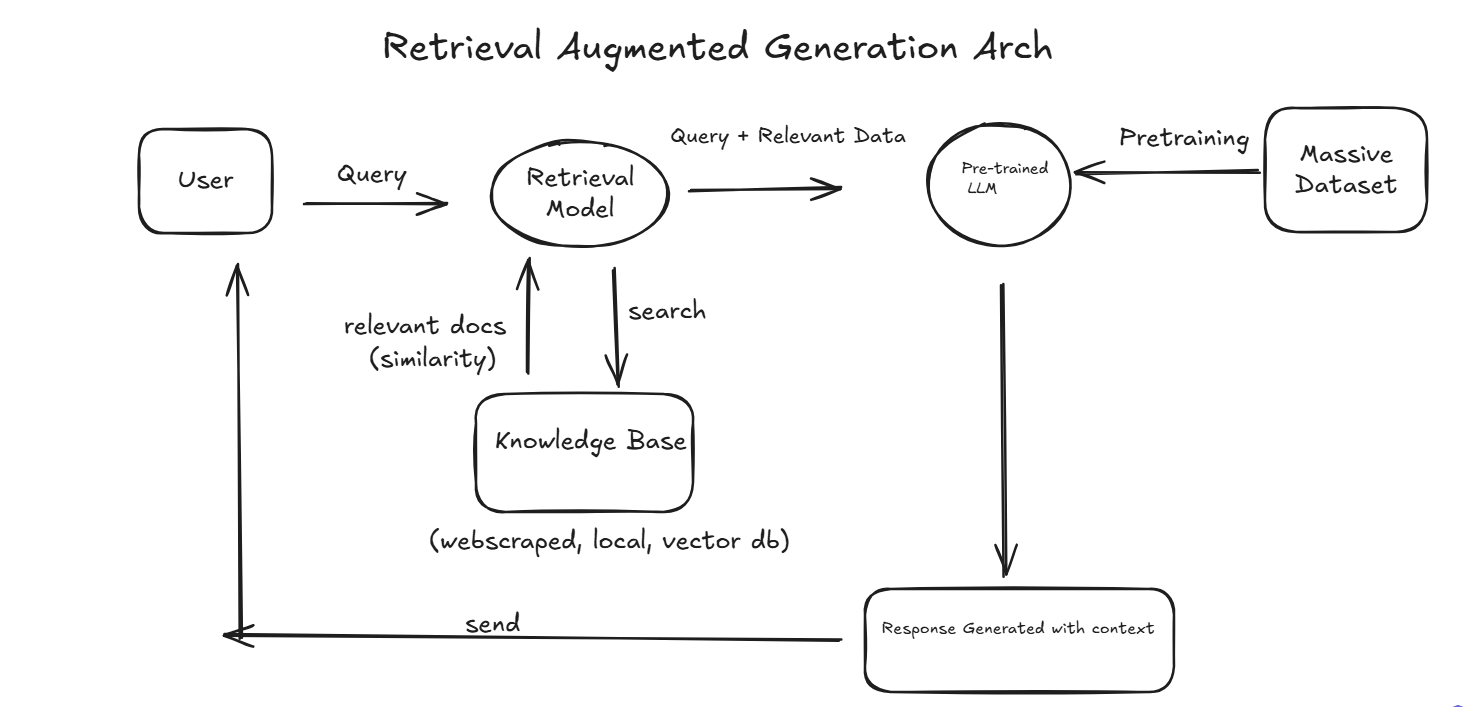

In [5]:
#importing json file for context 

import json

with open('kieler_woche.json', "r", encoding='utf-8') as input_file:    
    knowledge_base = json.load(input_file)

# knowledge_base

In [9]:
event_texts = []
for event in knowledge_base:
    # Build a single string for each event
    text = f"Event Name: {event['event_name']}\nDate: {event['date']}\nTime: {event['time']}\nLocation: {event['location']}\nDescription: {event['description']}"
    event_texts.append(text)

# Now event_texts is a list of strings ready for embedding
print(event_texts[0])

Event Name: Segelcamp
Date: 2025-6-20
Time: 09:00 - 10:00
Location: Kiellinie
Description: Annual sailing camp in Kiel offering over 30 sailing courses for children (ages 6–16) and adults. Children learn on Optimists and Aira yachts, led by expert instructors. Adults can enjoy evening and weekend sailing experiences. Registration needed for many courses, but spontaneous participation is possible on open camp weekends.



Pulling the embed model in terminal: ollama pull nomic-embed-text 
Embedding Model: nomic-embed-text

In [7]:
from ollama import embed

# Generate an embedding for a single input
response = embed(model='nomic-embed-text', input='opencampus is the best!')

# Access the embedding vector
embedding = response['embeddings']
print(embedding)
print(len(embedding[0]))

[[-0.0412678, 0.06608027, -0.17816535, -0.016620873, 0.021247312, -0.026373042, -0.0119793, 0.017040977, -0.010252768, -0.031976502, 0.050766386, -0.019003214, 0.045599326, -0.008368952, 0.012151578, 0.020968186, -0.040141094, -0.062134974, -0.030790789, -0.0075722127, -0.016742721, -0.02944686, -0.011470461, 0.032471623, 0.089676574, 0.053600688, -0.027177105, 0.019489678, -0.0077709737, 0.058896177, 0.07544069, -0.028481, 0.021120152, 0.010174547, 0.04322997, 0.03385851, -0.005307172, 0.011571915, -0.005141447, 0.001718461, 0.041858558, 0.0096085835, 0.031938963, -0.0054821237, 0.048820492, -0.07657891, 0.02049179, 0.044661, 0.050678246, -0.0710807, -0.020452922, -0.028743252, -0.026590513, 0.008545458, 0.06534198, -0.019189123, -0.018014386, -0.011383249, 0.007945101, 0.016238298, 0.085204676, 0.030184733, 0.0013785248, 0.06265975, 0.019743983, 0.05231329, -0.012230805, 0.07120509, -0.008263331, -0.012082112, 0.057253916, 0.0058059525, -0.002888794, 0.012905656, -0.019585324, 0.0199

In [10]:
# Generate an embedding for a batch input
response = embed(model='nomic-embed-text', input= event_texts)

# Access the embedding vectors
embedding = response['embeddings']

print(len(embedding), len(embedding[0]), len(embedding[0]))

15 768 768


In [11]:
import numpy as np 
vectors = np.array(embedding)

query = np.array(embed(model='nomic-embed-text', input='I am interested in Music Concerts in Kieler Woche')['embeddings'])

Euclidean Distance

In [12]:
# Compute Euclidean distances
differences = vectors - query  # shape: (n_vectors, vector_dim)
distances = np.linalg.norm(differences, axis=1)

# Index of closest vector
closest_index = np.argmin(distances)

# Sorted indices by distance
sorted_indices = np.argsort(distances)

print("Closest vector index:", closest_index)
print("Distance:", distances[closest_index])
print("Sorted indices by distance:", sorted_indices)

Closest vector index: 5
Distance: 0.750716302887151
Sorted indices by distance: [ 5  1  2 13 10 14  6 12  0  3  7  8  9  4 11]


In [14]:
print(event_texts[closest_index])

Event Name: STILLaLIVE Concert at Kiel Week
Date: 2025-06-22
Time: 10:00
Location: Sailing Arena Schilksee
Description: Popular live band STILLaLIVE from Lower Saxony and Hamburg performs energetic shows with hits from the 80s, 90s, 2000s, and today — 100% live, creating a lively atmosphere for singing, dancing, and celebrating at Kiel Week.


In [16]:
# Sort festival_talks according to the sorted_indices
sorted_events = [event_texts[i] for i in sorted_indices]

# Optionally print it
for num, talk in enumerate(sorted_events):
    print(num+1, talk)
    print()

1 Event Name: STILLaLIVE Concert at Kiel Week
Date: 2025-06-22
Time: 10:00
Location: Sailing Arena Schilksee
Description: Popular live band STILLaLIVE from Lower Saxony and Hamburg performs energetic shows with hits from the 80s, 90s, 2000s, and today — 100% live, creating a lively atmosphere for singing, dancing, and celebrating at Kiel Week.

2 Event Name: Waterkant Festival
Date: 2025-06-20
Time: 10:00 - 20:00
Location: Kiellinie
Description: Innovation festival in Kiel gathering startups, business leaders, and experts. Over 90 sessions on AI, work future, oceans, energy, and democracy. Includes talks, workshops, and live music by the fjord. A place for networking, inspiration, and launching new ideas.

3 Event Name: OCEAN PARTY
Date: 2025-06-21
Time: 19:30
Location:  Bootshafen Kiel-Mitte
Description: Kiel Week kicks off with a high-energy Ocean Party featuring DJ MOISI, a spectacular light show, fire fountains, and heavy electronic beats at the SunExpress Ocean Funpark — perfect f

In [17]:
# k = 3 (number of docs to retrieve)

retrieved_events = sorted_events[:3]

In [18]:
from ollama import chat
from IPython.display import Markdown, display

retrieved_content = '\n\n'.join(retrieved_events)

chat_response = chat(model='gemma3:1b', messages=[
    {
    'role': 'user',
    'content': 'User Question:\nI am interested in Music Concerts in Kieler Woche\n\n' + 'Answer the user question on events in Kiel Week Festival as best as you can based on the retrieved events information\n\nRetrieved content:\n\n' + retrieved_content,
    },
])

display(Markdown(chat_response.message.content))

Okay, here’s a breakdown of events in Kiel Week based on the provided information:

*   **StillaLIVE Concert:** Scheduled for June 22, 2025, at the Sailing Arena Schilksee.
*   **Waterkant Festival:** Scheduled for June 20, 2025, from 10:00 to 20:00, at the Kiellinie.  It’s an innovation festival with talks, workshops, and live music.
*   **OCEAN PARTY:** Scheduled for June 21, 2025, from 19:30, at Bootshafen Kiel-Mitte. It features DJ MOISI, a light show, and fire fountains.

Do you want me to elaborate on any of these events, or perhaps provide more details (e.g., genre of music, specific activities)?

Cosine Similarity (dot product)

In [21]:
import numpy as np

# Example dummy vectors and query
# vectors = np.array([...])  # shape: (n_vectors, vector_dim)
# query = np.array([...])    # shape: (vector_dim,)

# Normalize vectors and query
vectors_norm = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
query_norm = (query / np.linalg.norm(query)).reshape(-1)

# Compute cosine similarities
cosine_similarities = np.dot(vectors_norm, query_norm)  # shape: (n_vectors,)

# Since higher similarity is better, we want argmax
closest_index_cosine = np.argmax(cosine_similarities)

# Sorted indices (highest similarity first)
sorted_indices_cosine = np.argsort(-cosine_similarities)

print("Closest vector index:", closest_index_cosine)
print("Cosine Similarity:", cosine_similarities[closest_index_cosine])
print("Sorted indices by similarity:", sorted_indices_cosine)


Closest vector index: 5
Cosine Similarity: 0.7182124730874978
Sorted indices by similarity: [ 5  1  2 13 10 14  6 12  0  3  7  8  9  4 11]


Manhattan Distance (L1 distance)

In [22]:
# Compute Manhattan (L1) distances
differences = np.abs(vectors - query)  # element-wise absolute difference
distances = np.sum(differences, axis=1)

# Index of closest vector
closest_index_manahttan = np.argmin(distances)

# Sorted indices by distance
sorted_indices_manahttan = np.argsort(distances)

print("Closest vector index:", closest_index_manahttan)
print("Manhattan Distance:", distances[closest_index_manahttan])
print("Sorted indices by distance:", sorted_indices_manahttan)


Closest vector index: 5
Manhattan Distance: 16.5054379296065
Sorted indices by distance: [ 5 13  1  2 14 10  6  0 12  3  7  8  4  9 11]


In [23]:
# Sort festival_talks according to the sorted_indices
sorted_events_manhattan = [event_texts[i] for i in sorted_indices_manahttan]

# Optionally print it
for num, talk in enumerate(sorted_events_manhattan):
    print(num+1, talk)
    print()

1 Event Name: STILLaLIVE Concert at Kiel Week
Date: 2025-06-22
Time: 10:00
Location: Sailing Arena Schilksee
Description: Popular live band STILLaLIVE from Lower Saxony and Hamburg performs energetic shows with hits from the 80s, 90s, 2000s, and today — 100% live, creating a lively atmosphere for singing, dancing, and celebrating at Kiel Week.

2 Event Name: Music Theater
Date: 2025-06-26
Time: 18:00
Location: Düsternbrooker 
Description: A special music theater event for culture and dance

3 Event Name: Waterkant Festival
Date: 2025-06-20
Time: 10:00 - 20:00
Location: Kiellinie
Description: Innovation festival in Kiel gathering startups, business leaders, and experts. Over 90 sessions on AI, work future, oceans, energy, and democracy. Includes talks, workshops, and live music by the fjord. A place for networking, inspiration, and launching new ideas.

4 Event Name: OCEAN PARTY
Date: 2025-06-21
Time: 19:30
Location:  Bootshafen Kiel-Mitte
Description: Kiel Week kicks off with a high-en